# Part 3: Repeatability and reproducibility in vivo across all sites

## Before starting

We import the main libraries and color map we'll use:

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import csv
import os
import numpy as np
import glob
import nibabel as nib
from matplotlib.colors import LinearSegmentedColormap

def get_lipari_colormap():
    rgb_values = np.load('../code/lipari_colormap.npy')
    return LinearSegmentedColormap.from_list('Lipari', rgb_values, N=256)

# Load the Lipari colormap
custom_cmap = get_lipari_colormap()

## Figure 5b

First, we read the T1 values for white matter and cortex from each site for all volunteers. At this stage, we are not interested in the left and right hemisphere, so we'll take the mean of these two values:

In [10]:
# Define structures and visualization settings
structures_to_plot = ['Cerebral-White-Matter', 'Cerebral-Cortex']
sns.set_theme()

# File paths for different hospital datasets
hospital_file_paths = {
    'Cardiff': r'..\..\path\to\Cardiff_brain_roi_T1.csv',
    'Leiden': r'..\..\path\to\Leiden_brain_roi_T1.csv',
    'London 1': r'..\..\path\to\London1_brain_roi_T1.csv',
    'London 2': r'..\..\path\to\London2_brain_roi_T1.csv',
    'Lund': r'..\..\path\to\Lund_brain_roi_T1.csv',
    'Vancouver': r'..\..\path\to\Vancouver_brain_roi_T1.csv'
}

# Detect CSV delimiter
def detect_delimiter(file_path):
    try:
        with open(file_path, 'r') as f:
            sample = f.read(4096)
            return csv.Sniffer().sniff(sample).delimiter
    except csv.Error:
        return ',' 

# Load and combine data
combined_data = pd.DataFrame()
for hospital, file_path in hospital_file_paths.items():
    try:
        df = pd.read_csv(file_path, delimiter=detect_delimiter(file_path))
        df_filtered = df[(df['StructName'].str.contains('|'.join(structures_to_plot))) &
                         (df['rec'] == 'LLRv1') & (df['run'] == 1)].copy()
        df_filtered['Hospital'] = hospital
        combined_data = pd.concat([combined_data, df_filtered], ignore_index=True)
    except Exception as e:
        print(f"Error processing {hospital}: {e}")

# Extract base structure names and compute mean per volunteer per structure
combined_data['BaseStructName'] = combined_data['StructName'].str.replace('Left-|Right-', '', regex=True)
averaged_data = combined_data.groupby(['sub', 'Hospital', 'BaseStructName'], as_index=False)['Mean'].mean()
averaged_data.rename(columns={'BaseStructName': 'StructName'}, inplace=True)
averaged_data['Hospital'] = pd.Categorical(averaged_data['Hospital'], categories=sorted(averaged_data['Hospital'].unique()), ordered=True)


We perform first a one-way ANOVA analysis to check for significant differences:

In [8]:
# ANOVA analysis
anova_results = {}
for struct_name in averaged_data['StructName'].unique():
    structure_data = averaged_data[averaged_data['StructName'] == struct_name]
    hospital_groups = [group['Mean'].values for _, group in structure_data.groupby('Hospital')]
    f_stat, p_val = f_oneway(*hospital_groups)
    anova_results[struct_name] = {'F-statistic': f_stat, 'p-value': p_val}


for struct_name, result in anova_results.items():
    print(f"ANOVA results for {struct_name}:")
    print(f"  F-statistic: {result['F-statistic']:.4f}")
    print(f"  p-value: {result['p-value']:.4f}\n")

ANOVA results for Cerebral-Cortex:
  F-statistic: 0.9247
  p-value: 0.4724

ANOVA results for Cerebral-White-Matter:
  F-statistic: 1.1618
  p-value: 0.3402



Finally, we plot the results:

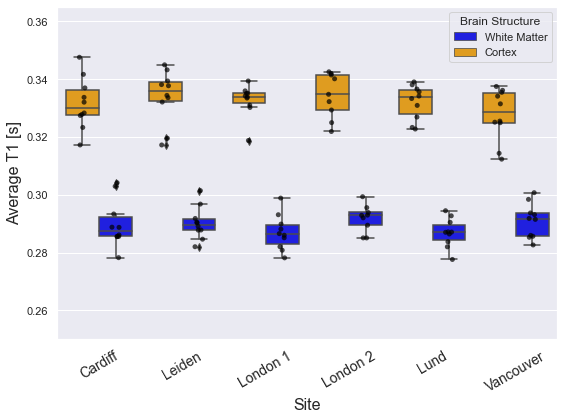

In [4]:
# Plot results
plt.figure(figsize=(8, 6))
flierprops = {'marker': 'd', 'markerfacecolor': 'k', 'markersize': 5, 'linestyle': 'none'}
ax = sns.boxplot(x='Hospital', y='Mean', hue='StructName', data=averaged_data,
                 palette={'Cerebral-White-Matter': 'blue', 'Cerebral-Cortex': 'orange'},
                 flierprops=flierprops)

sns.stripplot(x='Hospital', y='Mean', hue='StructName', data=averaged_data,
              dodge=True, marker='o', alpha=0.7,
              palette={'Cerebral-White-Matter': 'black', 'Cerebral-Cortex': 'black'})

handles, labels = ax.get_legend_handles_labels()
new_labels = {'Cerebral-White-Matter': 'White Matter', 'Cerebral-Cortex': 'Cortex'}
new_handles = [handles[labels.index(key)] for key in new_labels]
ax.legend(new_handles, [new_labels[key] for key in new_labels], title='Brain Structure')

plt.xticks(rotation=30, fontsize=14)
plt.xlabel('Site', fontsize=16)
plt.ylabel('Average T1 [s]', fontsize=16)
plt.ylim([0.25, 0.365])
plt.tight_layout()
plt.show()

## Figure 7

For this figure, first we load and compute the average T1 map from the average map per each site:

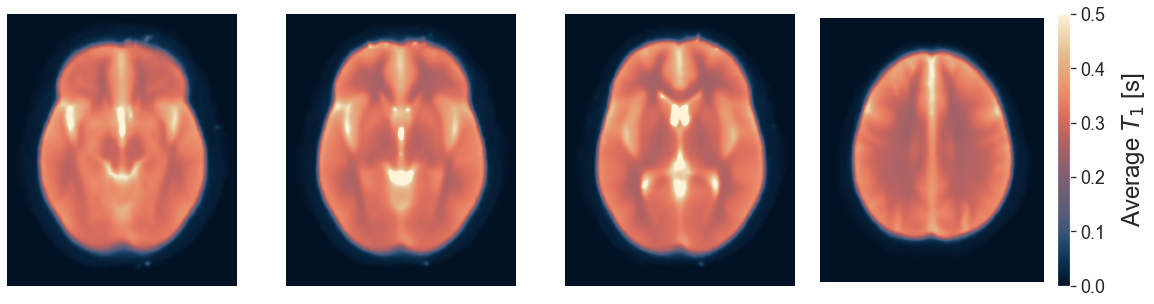

In [20]:
file_paths = [
    "/../../path/to/Lund_T1map_mean.nii.gz",
    "/../../path/to/Leiden_T1map_mean.nii.gz",
    "/../../path/to/Vancouver_T1map_mean.nii.gz",
    "/../../path/to/London1_T1map_mean.nii.gz",
    "/../../path/to/Cardiff_T1map_mean.nii.gz",
    "/../../path/to/London2_T1map_mean.nii.gz"
]

all_images = []

# Load average T1 maps
for file_path in file_paths:
    if os.path.exists(file_path):  
        img = nib.load(file_path)
        all_images.append(np.array(img.dataobj))

# Compute average T1 map
img_tot = np.stack(all_images, axis=0)
mean_img_tot = np.mean(img_tot, axis=0)

# Select slices to plot
num_slices = mean_img_tot.shape[2]
center_slice = num_slices // 2
selected_slices = [center_slice - 35, center_slice - 28, center_slice - 20, center_slice + 10]

# Plot
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, slice_idx in enumerate(selected_slices):
    rotated_slice = np.rot90(mean_img_tot[:, :, slice_idx], k=1)
    im = axes[i].imshow(rotated_slice, cmap=custom_cmap, vmin=0, vmax=0.500)
    axes[i].axis('off')

cbar = fig.colorbar(im)
cbar.set_label(r'Average $T_{1}$ [s]', labelpad=15, fontsize=24)
cbar.ax.tick_params(labelsize=18)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


Then we load and compute the average T1 map from the std map per each site:

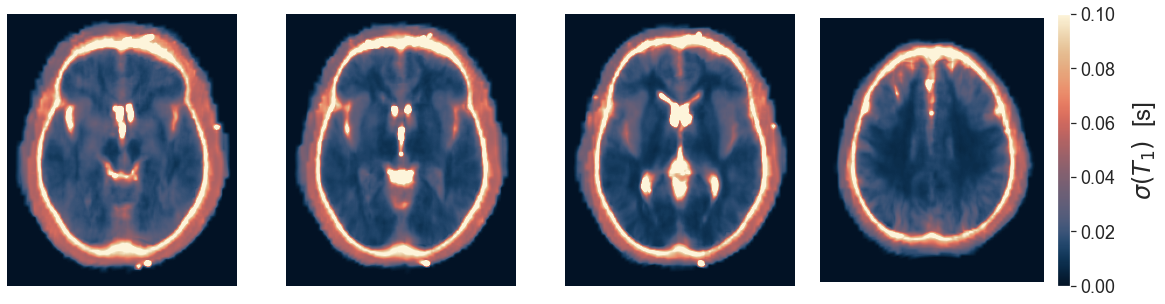

In [23]:
file_paths = [
    "/../../path/to/Lund_T1map_std.nii.gz",
    "/../../path/to/Leiden_T1map_std.nii.gz",
    "/../../path/to/Vancouver_T1map_std.nii.gz",
    "/../../path/to/London1_T1map_std.nii.gz",
    "/../../path/to/Cardiff_T1map_std.nii.gz",
    "/../../path/to/London2_T1map_std.nii.gz"
]

all_images = []

# Load std T1 maps
for file_path in file_paths:
    if os.path.exists(file_path):  
        img = nib.load(file_path)
        all_images.append(np.array(img.dataobj))

# Compute average T1 map
img_tot = np.stack(all_images, axis=0)
mean_img_tot = np.mean(img_tot, axis=0)

# Select slices to plot
num_slices = mean_img_tot.shape[2]
center_slice = num_slices // 2
selected_slices = [center_slice - 35, center_slice - 28, center_slice - 20, center_slice + 10]

# Plot
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, slice_idx in enumerate(selected_slices):
    rotated_slice = np.rot90(mean_img_tot[:, :, slice_idx], k=1)
    im = axes[i].imshow(rotated_slice, cmap=custom_cmap, vmin=0, vmax=0.100)
    axes[i].axis('off')

cbar = fig.colorbar(im)
cbar.set_label(r'$\sigma(T_{1})$  [s]', labelpad=15, fontsize=24)
cbar.ax.tick_params(labelsize=18)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


## Figure 8a

From the .csv files, specific to each site, we can read and plot the histograms of the T1 maps in white matter (WM) and cortex (GM) across the whole brain for all volunteers. The average distribution from each site is represented by a thick line, and with the standard deviation as shadowed line around it:

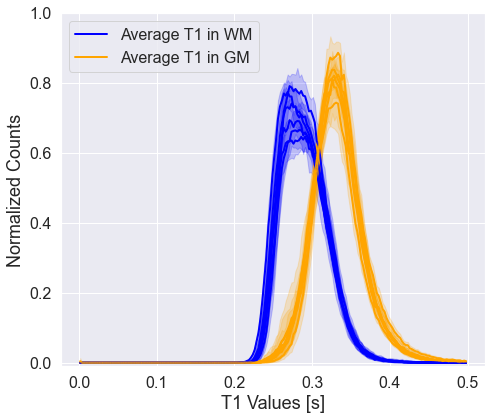

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List of file paths for different hospitals
file_paths = [
    r'..\..\path\to\Lund_hist_T1.csv',
    r'..\..\path\to\Vancouver_hist_T1.csv',
    r'..\..\path\to\Leiden_hist_T1.csv',
    r'..\..\path\to\London1_hist_T1.csv',
    r'..\..\path\to\Cardiff_hist_T1.csv',
    r'..\..\path\to\London2_hist_T1.csv'
]


# Read and combine data
dfs = []
for file_path, hospital_name in zip(file_paths, hospital_names):
    df = pd.read_csv(file_path, usecols=['sub', 'run', 'Pos', 'WM', 'GM'])
    df['Hospital'] = hospital_name
    dfs.append(df)

df_combined = pd.concat(dfs, ignore_index=True)

# Filter for specific runs
df_run = df_combined[df_combined['run'] == 1].copy()
df_run2 = df_combined[df_combined['run'] == 2].copy()
df_run1['Run'] = 'Run 1'
df_run2['Run'] = 'Run 2'
df_combined_runs = pd.concat([df_run1, df_run2], ignore_index=True)
df_combined_runs = df_run1

# Normalize WM and GM values per hospital
df_combined_runs['WM_norm'] = df_combined_runs.groupby('Hospital')['WM'].transform(lambda x: x / x.max())
df_combined_runs['GM_norm'] = df_combined_runs.groupby('Hospital')['GM'].transform(lambda x: x / x.max())
mean_wm_norm_overall = df_combined_runs.groupby(['Pos', 'Hospital'])['WM_norm'].mean().unstack()
mean_gm_norm_overall = df_combined_runs.groupby(['Pos', 'Hospital'])['GM_norm'].mean().unstack()


plt.figure(figsize=(7, 6))
# Plot mean normalized values
for hospital in hospital_names:
    sns.lineplot(x=mean_wm_norm_overall.index, y=mean_wm_norm_overall[hospital], label=f'Mean WM - {hospital}', color='blue', linestyle='-', linewidth=2)
    sns.lineplot(x=mean_gm_norm_overall.index, y=mean_gm_norm_overall[hospital], label=f'Mean GM - {hospital}', color='orange', linestyle='-', linewidth=2)
# Plot individual normalized values
sns.lineplot(data=df_combined_runs, x='Pos', y='WM_norm', hue='Run', palette={'Run 1': 'blue', 'Run 2': 'blue'}, style='Hospital', linewidth=0.7, alpha=0.2, legend=False)
sns.lineplot(data=df_combined_runs, x='Pos', y='GM_norm', hue='Run', palette={'Run 1': 'orange', 'Run 2': 'orange'}, style='Hospital', linewidth=0.7, alpha=0.2, legend=False)

plt.xlabel('T1 Values [s]', fontsize=18)
plt.ylabel('Normalized Counts', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc='upper left', title_fontsize='16', labels=['Average T1 in WM', 'Average T1 in GM'])
plt.ylim(-0.01, 1)
plt.tight_layout()
sns.set_theme()
plt.show()


## Figure 8b

For this figure, we read the T1 values for white matter, cerebral cortex, cerebellum white matter, cerebellum cortex, putamen, thalamus and caudata from each site for all volunteers. We want first to check whether they are significantly different for hemisphere: 

In [26]:
# File paths for different hospital datasets
hospital_file_paths = {
    'Cardiff': r'..\..\path\to\Cardiff_brain_roi_T1.csv',
    'Leiden': r'..\..\path\to\Leiden_brain_roi_T1.csv',
    'London 1': r'..\..\path\to\London1_brain_roi_T1.csv',
    'London 2': r'..\..\path\to\London2_brain_roi_T1.csv',
    'Lund': r'..\..\path\to\Lund_brain_roi_T1.csv',
    'Vancouver': r'..\..\path\to\Vancouver_brain_roi_T1.csv'
}

# Detect CSV delimiter
def detect_delimiter(file_path):
    try:
        with open(file_path, 'r') as f:
            sample = f.read(4096)
            return csv.Sniffer().sniff(sample).delimiter
    except csv.Error:
        return ','

# Specify the columns to read, including 'rec'
columns_to_read = ['sub', 'run', 'StructName', 'Mean', 'rec']

# Load and combine data
combined_data = pd.DataFrame()
for hospital, file_path in hospital_file_paths.items():
    try:
        df = pd.read_csv(file_path, delimiter=detect_delimiter(file_path), usecols=columns_to_read)
        df.dropna(inplace=True)  # Exclude NaN values
        df_filtered = df[(df['StructName'].str.contains('|'.join([
            'Left-Cerebral-White-Matter', 'Right-Cerebral-White-Matter',
            'Left-Cerebral-Cortex', 'Right-Cerebral-Cortex',
            'Left-Cerebellum-White-Matter', 'Right-Cerebellum-White-Matter',
            'Left-Cerebellum-Cortex', 'Right-Cerebellum-Cortex',
            'Left-Thalamus', 'Right-Thalamus',
            'Left-Caudate', 'Right-Caudate',
            'Left-Putamen', 'Right-Putamen'
        ]))) & (df['rec'] == 'LLRv1') & (df['run'] == 1)].copy()
        df_filtered['Hospital'] = hospital
        combined_data = pd.concat([combined_data, df_filtered], ignore_index=True)
    except Exception as e:
        print(f"Error processing {hospital}: {e}")

combined_data['Side'] = combined_data['StructName'].apply(lambda x: 'Left' if 'Left' in x else ('Right' if 'Right' in x else 'None'))
combined_data['Structure'] = combined_data['StructName'].replace({
    'Left-Cerebral-White-Matter': 'Cerebral-White-Matter',
    'Right-Cerebral-White-Matter': 'Cerebral-White-Matter',
    'Left-Cerebral-Cortex': 'Cerebral-Cortex',
    'Right-Cerebral-Cortex': 'Cerebral-Cortex',
    'Left-Cerebellum-White-Matter': 'Cerebellum-White-Matter',
    'Right-Cerebellum-White-Matter': 'Cerebellum-White-Matter',
    'Left-Cerebellum-Cortex': 'Cerebellum-Cortex',
    'Right-Cerebellum-Cortex': 'Cerebellum-Cortex',
    'Left-Thalamus': 'Thalamus',
    'Right-Thalamus': 'Thalamus',
    'Left-Caudate': 'Caudate',
    'Right-Caudate': 'Caudate',
    'Left-Putamen': 'Putamen',
    'Right-Putamen': 'Putamen'
})

# Perform ANOVA for each structure between left and right sides
anova_results = {}

for structure in combined_data['Structure'].unique():
    data = combined_data[combined_data['Structure'] == structure]
    f_value, p_value = stats.f_oneway(
        data[data['Side'] == 'Left']['Mean'],
        data[data['Side'] == 'Right']['Mean']
    )
    anova_results[structure] = {'F-value': f_value, 'p-value': p_value}

# Display the ANOVA results
df_anova_results = pd.DataFrame(anova_results).T
print(df_anova_results)


                          F-value   p-value
Cerebral-White-Matter    0.110185  0.740533
Cerebral-Cortex          2.158656  0.144475
Cerebellum-White-Matter  1.558589  0.214386
Cerebellum-Cortex        0.038201  0.845381
Thalamus                 0.739254  0.391673
Caudate                  0.000002  0.998902
Putamen                  0.021235  0.884394


Then we can plot them:

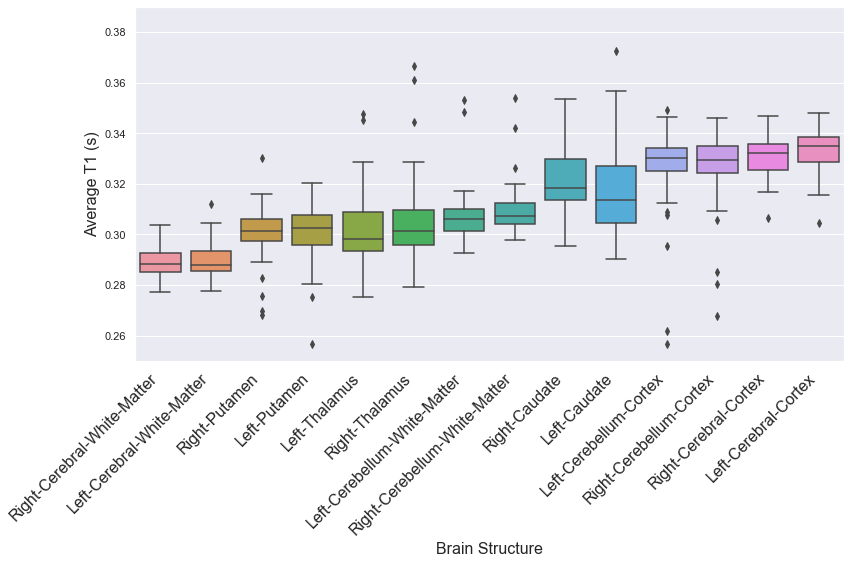

In [27]:
mean_T1_by_structure = combined_data.groupby('StructName')['Mean'].mean().sort_values()
combined_data['StructName'] = pd.Categorical(
    combined_data['StructName'], categories=mean_T1_by_structure.index, ordered=True
)

sns.set_theme()
plt.figure(figsize=(12, 8))
sns.boxplot(x='StructName', y='Mean', data=combined_data)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.xlabel('Brain Structure', fontsize=16)
plt.ylabel('Average T1 (s)', fontsize=16)
plt.ylim([0.25, 0.39])
plt.tight_layout()
plt.show()


## Figure 9

For Figure 9a, we read the T1 values for white matter and cortex for each hemisphere, then we calculate the mean T1 and the differences from the mean T1. Finally we plot the data:

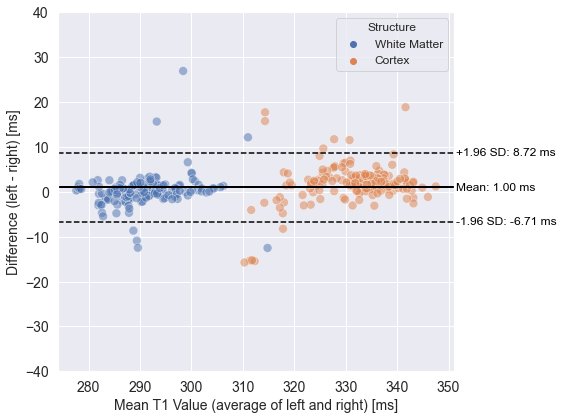

In [32]:
file_paths = [
    r'..\..\path\to\Cardiff_brain_roi_T1.csv',
    r'..\..\path\to\Leiden_brain_roi_T1.csv',
    r'..\..\path\to\London1_brain_roi_T1.csv',
    r'..\..\path\to\London2_brain_roi_T1.csv',
    r'..\..\path\to\Lund_brain_roi_T1.csv',
    r'..\..\path\to\Vancouver_brain_roi_T1.csv'
]

# List of structures to plot
structures_to_plot = [
    'Left-Cerebral-White-Matter', 'Right-Cerebral-White-Matter',
    'Left-Cerebral-Cortex', 'Right-Cerebral-Cortex'
]

def detect_delimiter(file_path):
    with open(file_path, 'r') as f:
        sample = f.read(4096) 
        sniffer = csv.Sniffer()
        try:
            return sniffer.sniff(sample).delimiter
        except csv.Error:
            return ','  

# Function to process each file and calculate Bland-Altman plot data
def process_file(file_path):
    hospital_name = os.path.basename(os.path.dirname(os.path.dirname(file_path)))
    delimiter = detect_delimiter(file_path)
    
    # Read relevant columns from the CSV file
    columns_to_read = ['sub', 'run', 'StructNameNoSide', 'StructName', 'Mean']
    df = pd.read_csv(file_path, delimiter=delimiter, usecols=columns_to_read)
    
    df['Hospital'] = hospital_name
    filtered_data = df[df['StructName'].isin(structures_to_plot)]
    structure_data = filtered_data.groupby('StructName')['Mean'].apply(list)
    
    # Calculate differences and means for Bland-Altman plot
    def calculate_diff_and_means(left_data, right_data):
        diffs = (np.array(left_data) - np.array(right_data)) * 1000  
        means = ((np.array(left_data) + np.array(right_data)) / 2) * 1000  
        return diffs, means
    
    results = {}
    structure_pairs = [
        ('Left-Cerebral-White-Matter', 'Right-Cerebral-White-Matter'),
        ('Left-Cerebral-Cortex', 'Right-Cerebral-Cortex')
    ]
    
    for left_structure, right_structure in structure_pairs:
        if left_structure in structure_data and right_structure in structure_data:
            left_data = structure_data[left_structure]
            right_data = structure_data[right_structure]
            diffs, means = calculate_diff_and_means(left_data, right_data)
            results[(left_structure, right_structure)] = {'means': means, 'diffs': diffs}
    
    # Prepare data for plotting
    plot_data = []
    for (left, right), data in results.items():
        df_plot = pd.DataFrame({
            'Mean': data['means'],
            'Difference': data['diffs'],
            'Structure': f'{left} vs {right}',
            'Hospital': hospital_name
        })
        plot_data.append(df_plot)
    
    return pd.concat(plot_data), filtered_data

# Process all files and combine results
all_data = [process_file(file_path) for file_path in file_paths]
plot_df = pd.concat([item[0] for item in all_data], ignore_index=True)
filtered_data = pd.concat([item[1] for item in all_data], ignore_index=True)

structure_label_map = {
    'Left-Cerebral-White-Matter vs Right-Cerebral-White-Matter': 'White Matter',
    'Left-Cerebral-Cortex vs Right-Cerebral-Cortex': 'Cortex'
}
plot_df['Structure'] = plot_df['Structure'].map(structure_label_map)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x='Mean', y='Difference', hue='Structure', s=80, alpha=0.5)

mean_diff = np.mean(plot_df['Difference'])
std_diff = np.std(plot_df['Difference'], ddof=1)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

plt.axhline(mean_diff, color='black', linestyle='-', linewidth=2)
plt.axhline(upper_limit, color='black', linestyle='--')
plt.axhline(lower_limit, color='black', linestyle='--')
plt.text(np.max(plot_df['Mean']) + 4, mean_diff, f'Mean: {mean_diff:.2f} ms', 
         verticalalignment='center', fontsize=12, color='black')
plt.text(np.max(plot_df['Mean']) + 4, upper_limit, f'+1.96 SD: {upper_limit:.2f} ms', 
         verticalalignment='center', fontsize=12, color='black')
plt.text(np.max(plot_df['Mean']) + 4, lower_limit, f'-1.96 SD: {lower_limit:.2f} ms', 
         verticalalignment='center', fontsize=12, color='black')
plt.xlabel('Mean T1 Value (average of left and right) [ms]', fontsize=14)
plt.ylabel('Difference (left - right) [ms]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([-40, 40])
plt.legend(fontsize=12, title='Structure')
plt.tight_layout()
plt.show()


Similarly, for Figure 9b, we read the T1 values for white matter and cortex for each run. Then we calculate the average T1 and the differences from the average T1:

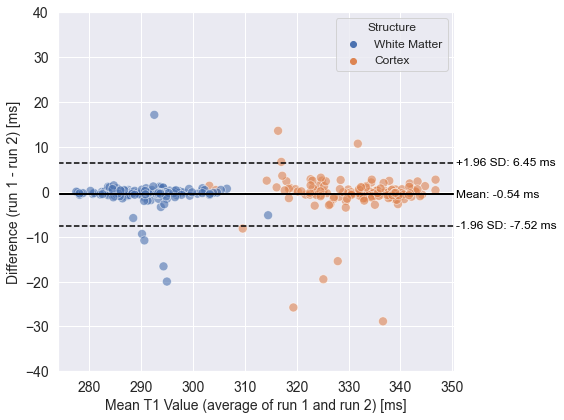

In [33]:
file_paths = [
    r'..\..\path\to\Cardiff_brain_roi_T1.csv',
    r'..\..\path\to\Leiden_brain_roi_T1.csv',
    r'..\..\path\to\London1_brain_roi_T1.csv',
    r'..\..\path\to\London2_brain_roi_T1.csv',
    r'..\..\path\to\Lund_brain_roi_T1.csv',
    r'..\..\path\to\Vancouver_brain_roi_T1.csv'
]

# List of structures to plot
structures_to_plot = [
    'Cerebral-White-Matter',
     'Cerebral-Cortex'
]

def detect_delimiter(file_path):
    with open(file_path, 'r') as f:
        sample = f.read(4096)  
        sniffer = csv.Sniffer()
        try:
            return sniffer.sniff(sample).delimiter
        except csv.Error:
            return ','  

def process_file(file_path):
    # Extract hospital name from the file path
    hospital_name = os.path.basename(os.path.dirname(os.path.dirname(file_path)))
    delimiter = detect_delimiter(file_path)
    
    columns_to_read = ['sub', 'run', 'StructNameNoSide', 'StructName', 'Mean']
    df = pd.read_csv(file_path, delimiter=delimiter, usecols=columns_to_read)
    
    # Add the hospital column
    df['Hospital'] = hospital_name
    
    # Filter the DataFrame for the selected structures
    filtered_data = df[df['StructNameNoSide'].isin(structures_to_plot)]
    
    # Calculate differences and means for the Bland-Altman plot
    def calculate_diff_and_means(run_1_data, run_2_data):
        diffs = ([(r1 - r2) * 1000 for r1, r2 in zip(run_1_data, run_2_data)])  # Convert to ms, absolute values
        means = [((r1 + r2) / 2) * 1000 for r1, r2 in zip(run_1_data, run_2_data)]  # Convert to ms
        return diffs, means
    
    # Calculate differences and means for each structure
    results = {}
    for structure in structures_to_plot:
        run_1_data = filtered_data[(filtered_data['StructNameNoSide'] == structure) & (filtered_data['run'] == 1)]['Mean'].values
        run_2_data = filtered_data[(filtered_data['StructNameNoSide'] == structure) & (filtered_data['run'] == 2)]['Mean'].values
        if len(run_1_data) == len(run_2_data):
            diffs, means = calculate_diff_and_means(run_1_data, run_2_data)
            results[structure] = {'means': means, 'diffs': diffs}
    
    plot_data = []
    for structure, data in results.items():
        df_plot = pd.DataFrame({
            'Mean': data['means'],
            'Difference': data['diffs'],
            'Structure': structure,
            'Hospital': hospital_name
        })
        plot_data.append(df_plot)
    
    return pd.concat(plot_data), filtered_data

all_data = [process_file(file_path) for file_path in file_paths]
plot_df = pd.concat([item[0] for item in all_data], ignore_index=True)
filtered_data = pd.concat([item[1] for item in all_data], ignore_index=True)
structure_label_map = {
    'Cerebral-White-Matter': 'White Matter',
    'Cerebral-Cortex': 'Cortex'
}

plot_df['Structure'] = plot_df['Structure'].map(structure_label_map)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x='Mean', y='Difference', hue='Structure', s=80, alpha=0.6)

# Calculate mean difference and confidence intervals
mean_diff = np.mean(plot_df['Difference'])
std_diff = np.std(plot_df['Difference'], ddof=1)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

plt.axhline(mean_diff, color='black', linestyle='-', linewidth=2)
plt.axhline(upper_limit, color='black', linestyle='--')
plt.axhline(lower_limit, color='black', linestyle='--')
plt.text(np.max(plot_df['Mean']) + 4, mean_diff, f'Mean: {mean_diff:.2f} ms', 
         verticalalignment='center', fontsize=12, color='black')
plt.text(np.max(plot_df['Mean']) + 4, upper_limit, f'+1.96 SD: {upper_limit:.2f} ms', 
         verticalalignment='center', fontsize=12, color='black')
plt.text(np.max(plot_df['Mean']) + 4, lower_limit, f'-1.96 SD: {lower_limit:.2f} ms', 
         verticalalignment='center', fontsize=12, color='black')
plt.xlabel('Mean T1 Value (average of run 1 and run 2) [ms]', fontsize=14)
plt.ylabel('Difference (run 1 - run 2) [ms]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([-40, 40])  # Adjust based on data range
plt.legend(fontsize=12, title='Structure')
plt.tight_layout()
plt.show()
